# Image Generation with Variational Autoencoders

We'll build a variational autoencoder (VAE) to generate images of handwritten digits inspired by the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We've organized these images in two folders named `train` and `test` in the GitHub repository https://github.com/DeepTrackAI/MNIST_dataset:

In [1]:
import os

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

train_path = os.path.join("MNIST_dataset", "mnist", "train")
train_images_paths = os.listdir(train_path)

print(f"{len(train_images_paths)} training images")

60000 training images


We load the data using `Deeptrack2.0`

In [2]:
import deeptrack as dt
import torch

dt.config.disable_image_wrapper()

train_paths = dt.sources.ImageFolder(root=train_path)
# test_paths = dt.sources.ImageFolder(root="test")

# train_sources = train_paths.product(flip_lr=[False, False], flip_ud=[False, False])
# train_sources = train_paths.constants(flip_lr=[False], flip_ud=[False])
# sources = dt.sources.Sources(train_sources)

pipeline = (
    dt.LoadImage(train_paths.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

2023-12-27 22:45:12.790690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


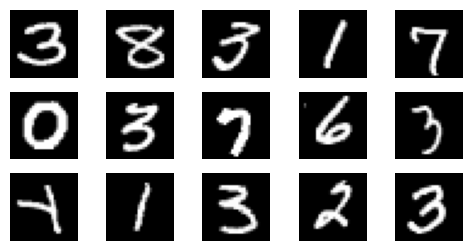

In [3]:
import matplotlib.pyplot as plt
from numpy import squeeze, random

fig, axs = plt.subplots(3, 5, figsize=((6, 3)))
for i, source in enumerate(random.choice(train_paths, 15)):  # range(15):
    image = pipeline(source)
    axs[i // 5, i % 5].imshow(squeeze(image), cmap="gray")
    axs[i // 5, i % 5].set_axis_off()

## Variational autoencoder
We define the autoencoder architecture.

In [4]:
# import deeplay as dl
# from torch.nn import Sigmoid, Identity

# # autoencoder = dl.ConvolutionalEncoderDecoder2d(
# #     in_channels=1,
# #     encoder_channels=[16, 16],
# #     decoder_channels=[16, 16],
# #     out_channels=1,
# #     out_activation=Sigmoid,
# # )
# # print(autoencoder)


# vae = dl.VAE2d(
#     input_size=(28, 28),
#     in_channels=1,
#     encoder_channels=[32, 64],
#     decoder_channels=[64, 32],
#     out_channels=1,
#     latent_dim=2,
#     out_activation=Sigmoid,
# )
# # print(vae)
# # vae.build()

In [5]:
import deeplay as dl
import torchmetrics as tm

vae_template = dl.VAE(latent_dim=2)

vae_regressor = vae_template.create()

In [6]:
from torch.utils.data import DataLoader

vae_trainer = dl.Trainer(max_epochs=200, accelerator="auto")

source = random.choice(train_paths, 4000)
# source = train_paths
pipe = pipeline & pipeline
train_dataset = dt.pytorch.Dataset(pipe, inputs=source)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


vae_trainer.fit(vae_regressor, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
   | Name  

Training: |          | 0/? [00:00<?, ?it/s]

/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [29]:
# vae_regressor.encode(torch.randn(1, 1, 28, 28))[0]
vae_regressor.decode(torch.randn(1, 2)).shape

torch.Size([1, 1, 28, 28])

In [32]:
torch.randn(1, 2)

tensor([-0.8378, -0.5628])

In [15]:
from torch.distributions.normal import Normal
import numpy as np

NUM_OF_IMAGES = 20
IMG_SIZE = 28
norm = Normal(0, 1)
grid_x = norm.icdf(torch.linspace(0.001, 0.999, NUM_OF_IMAGES))
grid_y = norm.icdf(torch.linspace(0.001, 0.999, NUM_OF_IMAGES))

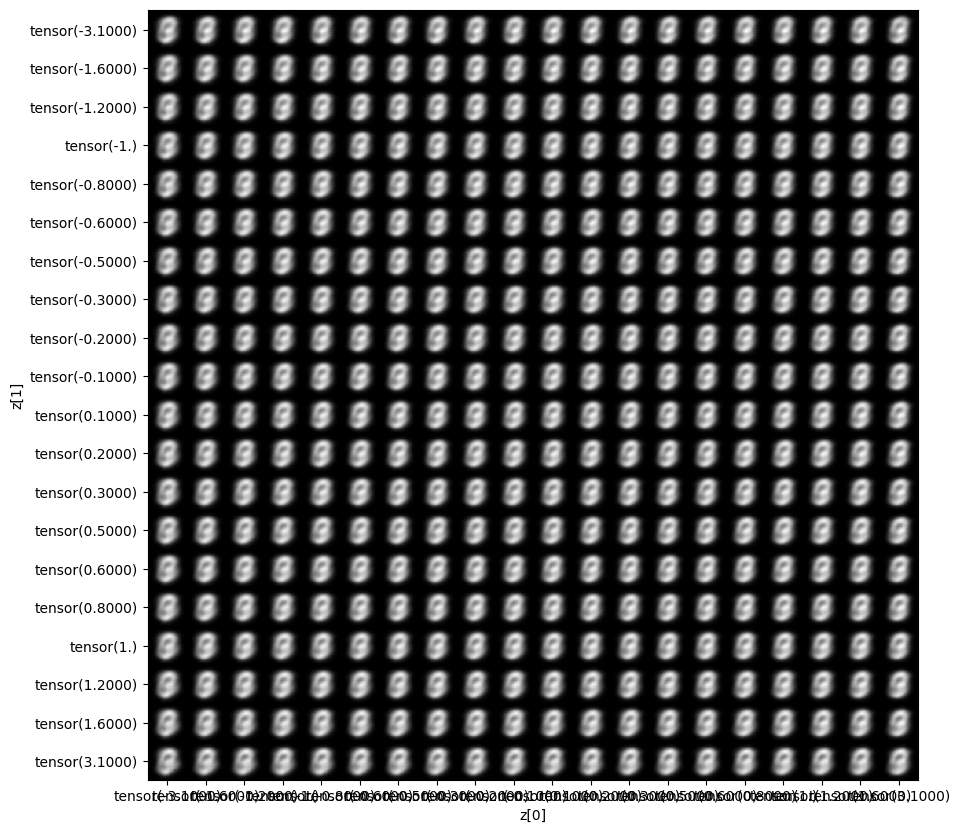

In [36]:
image = np.zeros((IMG_SIZE * NUM_OF_IMAGES,) * 2)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z = torch.stack((xi, yi)).unsqueeze(0)
        gimg = vae_regressor.decode(z).detach()
        image[
            i * IMG_SIZE : (i + 1) * IMG_SIZE,
            j * IMG_SIZE : (j + 1) * IMG_SIZE,
        ] = gimg.numpy().squeeze()
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
start = IMG_SIZE // 2
end = NUM_OF_IMAGES * IMG_SIZE + start
pixel_range = np.arange(start, end, IMG_SIZE)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [ ]:
from deeptrack.models.vaes import VAE

model = VAE(latent_dim=2)

In [ ]:
# model.encoder.summary()
model.decoder.summary()

We define the loss and the optimizer...

... and start the training.

In [ ]:
autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

autoencoder_trainer.fit(autoencoder_regressor, train_loader)

We visualize the autoencoder predictions.

In [ ]:
import matplotlib.pyplot as plt


for i in range(2):
    input_im, target_im = test_dataset[i]
    predicted_im = autoencoder_regressor(input_im).detach()
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

The training images are very similar. It can be that the autoencoder just learn to provide a centered particle, no matter what is the input (mode collapse). Let's check it out by making a prediction out of noise. 

Let's see if the autoencoder is able to generalize its predictions to particles located off center and with different size.

We check the predictions on this more challenging test set.

In [ ]:
for _ in range(3):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = autoencoder_regressor(input_im.unsqueeze(0)).detach()
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

We can train on the new dataset.

In [ ]:
new_train_dataset = SimulatedDatasetwithReplacement(
    new_pipeline, data_size=256, replace=0.2
)

new_train_loader = DataLoader(new_train_dataset, batch_size=8, shuffle=True)

new_autoencoder_regressor = regressor_template.create()

new_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

new_autoencoder_trainer.fit(new_autoencoder_regressor, new_train_loader)

In [ ]:
import matplotlib.pyplot as plt


for _ in range(4):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = new_autoencoder_regressor(input_im.unsqueeze(0)).detach()
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

## Improving the predictions
We can use a model with a larger number of activations to improve the results.

In [ ]:
import deeplay as dl
from torch.nn import Sigmoid

better_autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[8, 16, 32],
    decoder_channels=[32, 16, 8],
    out_channels=1,
    out_activation=Sigmoid,
)
print(better_autoencoder)

In [ ]:
better_regressor_template = dl.Regressor(
    model=better_autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)

better_autoencoder_regressor = better_regressor_template.create()

better_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

better_autoencoder_trainer.fit(better_autoencoder_regressor, new_train_loader)

In [ ]:
for _ in range(4):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = better_autoencoder_regressor(input_im.unsqueeze(0)).detach()

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")